# Project 2 - Polynomial Models for Boston House Prices

## Group members

* Michael Peralta (mikeperalta@csu.fullerton.edu)
   
* Brandon Xue (brandonx@csu.fullerton.edu)

### CPSC 483-02, Section ID: 33018

# Experiment 1
Load and examine the Boston dataset’s features, target values, and description.

In [1]:

# Experiment 1

import sklearn.datasets as sklearn_datasets
import pandas as pd


# Import the Boston house prices dataset
# (load)
boston_house_data = sklearn_datasets.load_boston()


# Print out various properties of the Boston house prices dataset
# (examine)
print("--- Loaded Boston dataset; Ready for examination")
print("*" * 30)
print("> *** BEGIN DESCRIPTION ***")
print(boston_house_data.DESCR) # description
print("> *** END DESCRIPTION ***")
print("*" * 30)
print()
print("> Features shape:", boston_house_data.data.shape)
print("> Feature names: ", boston_house_data.feature_names) # feature names
print("> Number of Features:", len(boston_house_data.data[0,:])) # features
print("> Number of Target values:", len(boston_house_data.target)) # targets




--- Loaded Boston dataset; Ready for examination
******************************
> *** BEGIN DESCRIPTION ***
.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of access

# Experiment 2
Use *sklearn.model_selection.train_test_split()* to split the features and values into separate training and test sets. Use 80% of the original data as a training set, and 20% for testing.


In [2]:
# Experiment 2
# Partition into training and testing sets


from sklearn import model_selection


# TODO: What is this?
# data_with_targets = zip(boston_house_data.data, boston_house_data.target)
# print("Data_with_targets:", data_with_targets)


# Load the boston data into a pandas data frame
boston_house_data_frame = pd.DataFrame(data=boston_house_data.data, columns=boston_house_data.feature_names)

# Add targets to same data frame so they stay paired with other data
boston_house_data_frame.insert(len(boston_house_data_frame.columns), 'TARGET', boston_house_data.target)

# Split the data into a training set (80%), and a test set (20%)
# train_test_split returns a list of the train-test split of inputs
boston_training_set, boston_testing_set = model_selection.train_test_split(
    boston_house_data_frame,  # Original data to split
    train_size=0.8,  # Retain 80% of the data for training (remaining becomes testing)
    random_state=113  # Randomize the data before splitting, but use a stable seed for repeatable results
)
print("Training set shape:", boston_training_set.shape)
print("Training set shape:", boston_training_set.shape)
print("Testing set shape:", boston_testing_set.shape)
print("Testing set shape:", boston_testing_set.shape)
print()



Training set shape: (404, 14)
Training set shape: (404, 14)
Testing set shape: (102, 14)
Testing set shape: (102, 14)



# Experiment 3
Create a *scatterplot* of the training set showing the relationship between the feature LSTAT and the target value MEDV.

***Question***: Does the relationship appear to be linear?

Text(0.5, 0.98, 'Training Data')

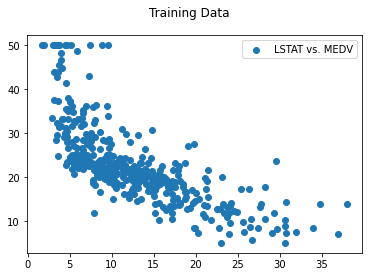

In [3]:
# Experiment 3. Scatter plot of training data

import matplotlib.pyplot as plt

# Ask pyplot for a figure and axis, for a new plot
fig, ax = plt.subplots()

# Show the relationship between feature LSTAT and TARGET values, using a scatter plot
ax.scatter(boston_training_set.LSTAT, boston_training_set.TARGET, label="LSTAT vs. MEDV")
ax.legend()
fig.suptitle("Training Data")

# TODO: What is this?
#retval = ax.set(xlabel="Training LSTAT (%)", ylabel="Training MEDV (1000 USD)", title="Training MEDV vs. Training LSTAT")

## Does the relationship appear to be linear?

The above relationship between the feature LSTAT and the target value MEDV does not quite appear to be linear. If we only examined LSTAT ranges from 10 to 25, it might, but the overall data appears to show a non-linear relationship.

# Experiment 4
With LSTAT as ***X*** and MEDV as ***t***, use *np.linalg.inv()* to compute ***w*** for the training set.

***Question***: What is the equation for MEDV as a linear function of LSTAT?

We will use the following formula to compute the weights:

$$
w = (X^TX)^{-1}X^Tt
$$

(found in the linear_regression_vectors_and_matrices.ipynb notebook)

The equation for MEDV as a linear function of LSTAT is written after the code below.

In [4]:

# Import numpy, yay
import numpy as np


# x_lstat_training will be LSTAT of the training set
# We can combine it with a preceding column of one's for the intercept
# (LSTAT will be the next column)

# Pull LSTAT from the training set, and stick it into a numpy array
x_lstat_training = np.array(boston_training_set["LSTAT"])  # Pull LSTAT from training
# print("x_lstat_training:", x_lstat_training)
print("x_lstat_training shape:", x_lstat_training.shape)
print()

# Now, X_lstat_linear_training will be the matrix we'll solve against (training data)
# Start with the x_lstat_training values in a column of a matrix
X_lstat_linear_training = x_lstat_training.reshape(x_lstat_training.shape[0], 1)
# Stick 1's for the intercept in the first column then the LSTAT column as the second column
X_lstat_linear_training = np.hstack((np.ones_like(X_lstat_linear_training), X_lstat_linear_training))
# print("X_lstat_linear_training: ", X)
print("X_lstat_linear_training shape:", X_lstat_linear_training.shape)
print()


# Build each part of the formula piece by piece
XTX = np.dot(X_lstat_linear_training.T, X_lstat_linear_training)
XTX_inv = np.linalg.inv(XTX)
XTt = np.dot(X_lstat_linear_training.T, boston_training_set["TARGET"])
lstat_linear_weights = np.dot(XTX_inv, XTt)
# print("XTX:", XTX)
print("XTX shape:", XTX.shape)
# print("XTX^-1:", XTX_inv)
print("XTX^-1 shape:", XTX_inv.shape)
print("XTt:", XTt)
print("XTt shape:", XTt.shape)
print("lstat_linear_weights:", lstat_linear_weights)
print("lstat_linear_weights shape:", lstat_linear_weights.shape)
print()



x_lstat_training shape: (404,)

X_lstat_linear_training shape: (404, 2)

XTX shape: (2, 2)
XTX^-1 shape: (2, 2)
XTt: [ 9152.4   96065.778]
XTt shape: (2,)
lstat_linear_weights: [34.38436369 -0.93878862]
lstat_linear_weights shape: (2,)



## Equation for MEDV as a linear function of LSTAT
The equation for MEDV as a linear function of LSTAT is:

$$
y = 34.38436369 + (-0.93878862 * \text{LSTAT})
$$

or rather:

$$
y = 34.38436369 -0.93878862(\text{LSTAT})
$$


# Experiment 5

Use **w** to add a line to your scatter plot from experiment *(3)*.

***Question***: How well does the model appear to fit the training set?


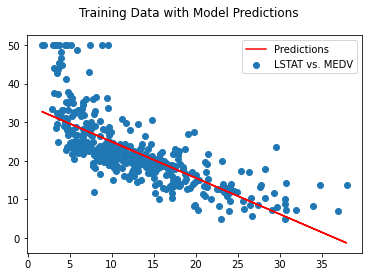

In [5]:

# Experiment 5


# Make some predictions for the training data
# i.e., show the model's linear ... line
predictions_lstat_linear_training = np.dot(X_lstat_linear_training, lstat_linear_weights)


# Ask pyplot for a figure and axis, for a new plot
fig, ax = plt.subplots()


# Show the relationship between feature LSTAT and TARGET values, using a scatter plot
# (training data)
ax.scatter(boston_training_set.LSTAT, boston_training_set.TARGET, label="LSTAT vs. MEDV")
ax.plot(x_lstat_training, predictions_lstat_linear_training, 'r-', label="Predictions")
fig.suptitle("Training Data with Model Predictions")
ax.legend()


# How well does the model appear to fit the training set?
The model fits ... not very well with the training set. It probably has a lot more error than we would like.

# Experiment 6
Use **w** to find the response for each value of the LSTAT attribute in the test set, then compute the test *MSE L* for the model.

x_lstat_testing shape: (102,)

X_lstat_linear_testing shape: (102, 2)

predictions_lstat_linear_testing shape: (102,)
boston_testing_set.TARGET: 22     15.2
202    42.3
368    50.0
335    21.1
461    17.7
       ... 
86     22.5
193    31.1
5      28.7
282    46.0
232    41.7
Name: TARGET, Length: 102, dtype: float64
boston_testing_set.TARGET shape: (102,)
MSE for the linear model: 39.95751318608693



Text(0.5, 0.98, 'Test Data vs. Linear Model')

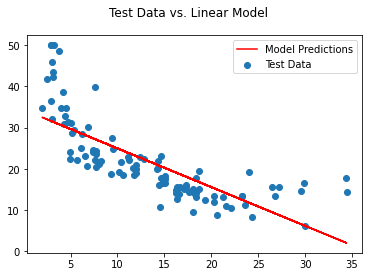

In [6]:

# Experiment 6

# Pull LSTAT from the testing set, and stick it into a numpy array
x_lstat_testing = np.array(boston_testing_set["LSTAT"])  # Pull LSTAT from testing
print("x_lstat_testing shape:", x_lstat_testing.shape)
# print("x_lstat_testing:", x_lstat_testing)
print()


# Now, X_lstat_linear_testing will be the matrix we'll predict against
# Start with the x_lstat values in a column of a matrix
X_lstat_linear_testing = x_lstat_testing.reshape(x_lstat_testing.shape[0], 1)
# Stick 1's for the intercept in the first column then the LSTAT column as the second column
X_lstat_linear_testing = np.hstack((np.ones_like(X_lstat_linear_testing), X_lstat_linear_testing))
# print("X_lstat_linear_testing: ", X_lstat_linear_testing)
print("X_lstat_linear_testing shape:", X_lstat_linear_testing.shape)
print()


#
predictions_lstat_linear_testing = np.dot(X_lstat_linear_testing, lstat_linear_weights)
print("predictions_lstat_linear_testing shape:", predictions_lstat_linear_testing.shape)

# TODO: Is there a more numpy-y way to do this?
print("boston_testing_set.TARGET:", boston_testing_set.TARGET)
print("boston_testing_set.TARGET shape:", boston_testing_set.TARGET.shape)
graph_x = []
graph_t = []
graph_y = []  # Build the graph as we traverse the predictions, to be sure we're pulling correct values
error_temp_sum = 0
for n in range(len(predictions_lstat_linear_testing)):
    
    lstat = boston_testing_set.LSTAT.iloc[n]
    graph_x.append(lstat)
    
    t = boston_testing_set.TARGET.iloc[n]
    graph_t.append(t)
    
    y = predictions_lstat_linear_testing[n]
    graph_y.append(y)
    
    error_squared = (t - y)**2
    error_temp_sum += error_squared
    
    # print("Prediction:", y)
    # print("Actual:", t)
    # print("Error Squared:", error_squared)
    # print()

mean_squared_error_linear = error_temp_sum / len(predictions_lstat_linear_testing)
print("MSE for the linear model:", mean_squared_error_linear)
print()


# Just for extra confidence, show a graph of the test data
fig, ax = plt.subplots()
ax.scatter(graph_x, graph_t, label="Test Data")
ax.plot(graph_x, graph_y, 'r-', label='Model Predictions')
ax.legend()
fig.suptitle("Test Data vs. Linear Model")

##  MSE For Linear Model

The MSE for the linear model appears to be: 39.95751318608693

# Experiment 7
Now add an *x 2* column to LSTAT’s *x* column in the training set, then repeat experiments *(4)* , *(5)*, and *(6)* for MEDV as a quadratic function of LSTAT.

***Question***: Does the quadratic polynomial do a better job of predicting the values in the test set?

## Building a Quadratic Matrix

In [7]:

# Experiment 7

# Build the new training matrix
# Same as before but add a new column representing LSTAT^2
x_lstat_training = np.array(boston_training_set["LSTAT"])  # Pull LSTAT again
x_squared_lstat_training = x_lstat_training**2
X_squared_lstat_training = x_squared_lstat_training.reshape(x_squared_lstat_training.shape[0], 1)
X_lstat_quadratic_training = x_lstat_training.reshape(x_lstat_training.shape[0], 1)  # One column matrix
lstat_training_ones = np.ones_like(X_lstat_quadratic_training)
X_lstat_quadratic_training = np.hstack((
    lstat_training_ones,
    X_lstat_quadratic_training,
    X_squared_lstat_training
))
print("lstat_training_ones shape:", lstat_training_ones.shape)
print("x_squared_lstat_training shape:", x_squared_lstat_training.shape)
print("X_lstat_quadratic_training:", X_lstat_quadratic_training)
print("X_lstat_quadratic_training shape:", X_lstat_quadratic_training.shape)
print()



lstat_training_ones shape: (404, 1)
x_squared_lstat_training shape: (404,)
X_lstat_quadratic_training: [[  1.      12.73   162.0529]
 [  1.       4.84    23.4256]
 [  1.      10.11   102.2121]
 ...
 [  1.       1.92     3.6864]
 [  1.       9.71    94.2841]
 [  1.       9.81    96.2361]]
X_lstat_quadratic_training shape: (404, 3)



## Performing Experiment 4 on the New Quadratic Matrix
With LSTAT as ***X*** and MEDV as ***t***, use *np.linalg.inv()* to compute ***w*** for the training set.

***Question***: What is the equation for MEDV as a ***QUADRATIC*** function of LSTAT?

In [8]:

# Experiment 7-4

# Build each part of the formula piece by piece
XTX = np.dot(X_lstat_quadratic_training.T, X_lstat_quadratic_training)
XTX_inv = np.linalg.inv(XTX)
XTt = np.dot(X_lstat_quadratic_training.T, boston_training_set["TARGET"])
lstat_quadratic_weights = np.dot(XTX_inv, XTt)
# print("XTX:", XTX)
print("XTX shape:", XTX.shape)
# print("XTX^-1:", XTX_inv)
print("XTX^-1 shape:", XTX_inv.shape)
print("XTt:", XTt)
print("XTt shape:", XTt.shape)
print("lstat_quadratic_weights:", lstat_quadratic_weights)
print("lstat_quadratic_weights shape:", lstat_quadratic_weights.shape)
print()

XTX shape: (3, 3)
XTX^-1 shape: (3, 3)
XTt: [   9152.4      96065.778  1347974.9532]
XTt shape: (3,)
lstat_quadratic_weights: [ 4.18618826e+01 -2.16340419e+00  3.82868299e-02]
lstat_quadratic_weights shape: (3,)



### What is the equation for MEDV as a ***QUADRATIC*** function of LSTAT?

The equation is:
$$
y = 41.8618826 + (-2.16340419 * \text{LSTAT}) + .0382868299(\text{LSTAT}^2)
$$

or rather

$$
y = 41.8618826 -2.16340419(\text{LSTAT}) + .0382868299(\text{LSTAT}^2)
$$


## Performing Experiment 5 on the new Quadratic Matrix
Use ***w*** to add a line to your scatter plot from experiment *(3)*.

***Question***: How well does the model appear to fit the training set?

Text(0.5, 0.98, 'Training Data vs. Quadratic')

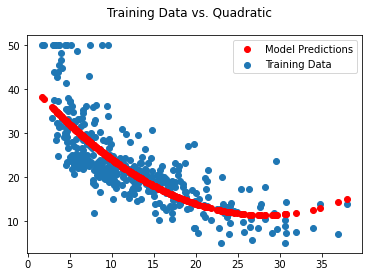

In [9]:

# Experiment 7-5

#
predictions_lstat_quadratic_training = np.dot(X_lstat_quadratic_training, lstat_quadratic_weights)

#
fig, ax = plt.subplots()
ax.scatter(X_lstat_quadratic_training[:, 1], boston_training_set.TARGET, label="Training Data")
ax.plot(
    X_lstat_quadratic_training[:, 1],
    predictions_lstat_quadratic_training,
    'ro',  # I guess a line doesn't work with this, so I'm using red dots
    label='Model Predictions'
)
ax.legend()
fig.suptitle("Training Data vs. Quadratic")



### How well does the model appear to fit the training set?
The model appears to fit the training set more closely than the linear model does. You can see it curving slightly to the visually perceptible curve of the training data. The only remaining issue seems to be the noise, and the training data points smashed up against the top-left area of the graph, which the model chose to ignore to fit better on the remaining data.

## Performing Experiment 6 on the New Quadratic Matrix
Use ***w*** to find the response for each value of the LSTAT attribute in the test set, then
compute the test *MSE L* for the model.

X_lstat_quadratic_testing shape: (102, 3)

predictions_lstat_quadratic_testing shape: (102,)
boston_testing_set.TARGET: 22     15.2
202    42.3
368    50.0
335    21.1
461    17.7
       ... 
86     22.5
193    31.1
5      28.7
282    46.0
232    41.7
Name: TARGET, Length: 102, dtype: float64
boston_testing_set.TARGET shape: (102,)
MSE for the quadratic model: 23.63811573222816



*** Just a recap:
MSE of Linear: 39.95751318608693
MSE of Quadratic: 23.63811573222816



Text(0.5, 0.98, 'Test Data vs. Quadratic Model')

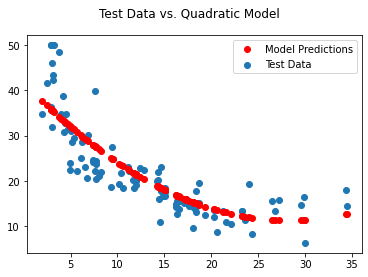

In [10]:

# Experiment 7-6



# Build the testing matrix
x_lstat_testing = np.array(boston_testing_set["LSTAT"])  # Pull LSTAT from testing
x_squared_lstat_testing = x_lstat_testing**2
X_lstat_quadratic_testing = np.hstack((
   np.ones_like(x_lstat_testing.reshape(x_lstat_testing.shape[0], 1)),
    x_lstat_testing.reshape(x_lstat_testing.shape[0], 1),
    x_squared_lstat_testing.reshape(x_squared_lstat_testing.shape[0], 1)
))
# print("X_lstat_quadratic_testing: ", X_lstat_quadratic_testing)
print("X_lstat_quadratic_testing shape:", X_lstat_quadratic_testing.shape)
print()

#
predictions_lstat_quadratic_testing = np.dot(X_lstat_quadratic_testing, lstat_quadratic_weights)
print("predictions_lstat_quadratic_testing shape:", predictions_lstat_quadratic_testing.shape)

# TODO: Is there a more numpy-y way to do this?
print("boston_testing_set.TARGET:", boston_testing_set.TARGET)
print("boston_testing_set.TARGET shape:", boston_testing_set.TARGET.shape)
graph_x = []
graph_t = []
graph_y = []  # Build the graph as we traverse the predictions, to be sure we're pulling correct values
error_temp_sum = 0
for n in range(len(predictions_lstat_quadratic_testing)):
    
    lstat = boston_testing_set.LSTAT.iloc[n]
    graph_x.append(lstat)
    
    t = boston_testing_set.TARGET.iloc[n]
    graph_t.append(t)
    
    y = predictions_lstat_quadratic_testing[n]
    graph_y.append(y)
    
    error_squared = (t - y)**2
    error_temp_sum += error_squared
    
    # print("Prediction:", y)
    # print("Actual:", t)
    # print("Error Squared:", error_squared)
    # print()

mean_squared_error_quadratic = error_temp_sum / len(predictions_lstat_quadratic_testing)
print("MSE for the quadratic model:", mean_squared_error_quadratic)
print()

print()
print()
print("*** Just a recap:")
print("MSE of Linear:", mean_squared_error_linear)
print("MSE of Quadratic:", mean_squared_error_quadratic)
print()


# Just for extra confidence, show a graph of the test data
fig, ax = plt.subplots()
ax.scatter(graph_x, graph_t, label="Test Data")
ax.plot(
    graph_x,
    graph_y,
    'ro',  # Lines don't work with this I guess, so using more dots hurrayyyy
    label='Model Predictions'
)
ax.legend()
fig.suptitle("Test Data vs. Quadratic Model")

## Does the quadratic polynomial do a better job of predicting the values in the test set?

Yes, the quadratic polynomial model does a better job of predicting the values in the test set. We can see from the above code output ("Recap" area), that the MSE of the linear model was about 40, while the MSE of the qudratic model was about 23 and a half. Since the quadratic model had a lower MSE on the test data, it does a better job of predicting the values in the test set.


# Experiment 8
Repeat experiment *(4)* with all 13 input features as ***X*** and using *np.linalg.lstsq()*. (See the Appendix to *Linear regression in vector and matrix format* for details of why we need to switch away from *np.linalg.inv()*, and the notes for *np.linalg.solve()* for why we shouldn’t use that either.)

***Question***: Does adding additional features improve the performance on the test set compared to using only LSTAT?

In [11]:

# Experiment 8


# Use pandas to build most of the matrix this time
X_linear_full_training = boston_training_set[[
    'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT'
]].to_numpy()
X_linear_full_training = np.hstack((
    np.ones((X_linear_full_training.shape[0], 1)),
    X_linear_full_training
))
print("Original columns:", boston_training_set.columns)
print("X_linear_full_training:", X_linear_full_training)
print("X_linear_full_training shape:", X_linear_full_training.shape)
print()


# Prompt tells us to just use np.linalg.lstsq() this time, because doing the formulastuffs is too slow/inaccurate
temp_result = np.linalg.lstsq(X_linear_full_training, boston_training_set["TARGET"], rcond=None)
weights_linear_full = temp_result[0]
residuals_linear_full = temp_result[1]
print("weights_linear_full:", weights_linear_full)
print("weights_linear_full shape:", weights_linear_full.shape)
print("residuals_linear_full:", residuals_linear_full)
print()





Original columns: Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'TARGET'],
      dtype='object')
X_linear_full_training: [[1.00000e+00 4.75470e-01 0.00000e+00 ... 1.84000e+01 3.96230e+02
  1.27300e+01]
 [1.00000e+00 1.27440e-01 0.00000e+00 ... 1.79000e+01 3.85410e+02
  4.84000e+00]
 [1.00000e+00 5.11358e+01 0.00000e+00 ... 2.02000e+01 2.60000e+00
  1.01100e+01]
 ...
 [1.00000e+00 1.83377e+00 0.00000e+00 ... 1.47000e+01 3.89610e+02
  1.92000e+00]
 [1.00000e+00 3.58090e-01 0.00000e+00 ... 1.74000e+01 3.91700e+02
  9.71000e+00]
 [1.00000e+00 2.92400e+00 0.00000e+00 ... 1.47000e+01 2.40160e+02
  9.81000e+00]]
X_linear_full_training shape: (404, 14)

weights_linear_full: [ 3.35486261e+01 -1.14331280e-01  3.30399664e-02  2.19911151e-02
  1.93047806e+00 -1.53459876e+01  4.11678898e+00 -5.20475977e-03
 -1.26111638e+00  3.52665352e-01 -1.37375084e-02 -1.01521476e+00
  9.98692962e-03 -4.90950094e-01]
weights_linear_full shape: (14,

## Equation for All Features

The equation using all features is then:

$$
y = \\
33.5486261 \\
- 0.114331280(\text{CRIM}) \\
+ 0.0330399664(\text{ZN}) \\
+ .0219911151(\text{INDUS}) \\
+ 1.93047806(\text{CHAS}) \\
- 0.153459876(\text{NOX}) \\
+ 4.11678898(\text{RM}) \\
- 0.00520475977(\text{AGE}) \\
- 1.26111638(\text{DIS}) \\
+ 0.352665352(\text{RAD}) \\
- 0.0137375084(\text{TAX}) \\
- 1.01521476(\text{PTRATIO}) \\
+ 0.00998692962(\text{B}) \\
- .490950094(\text{LSTAT}) \\
$$

## Improvement with Additional Features?
*Does adding additional features improve the performance on the test set compared to using only LSTAT?*

I guess this means we need to calculate MSE against the test set real quick


In [12]:

# Build the test set
X_linear_full_testing = boston_testing_set[[
    'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT'
]].to_numpy()
X_linear_full_testing = np.hstack((
    np.ones((X_linear_full_testing.shape[0], 1)),
    X_linear_full_testing
))
print("Original columns:", boston_testing_set.columns)
# print("X_linear_full_testing:", X_linear_full_testing)
print("X_linear_full_testing shape:", X_linear_full_testing.shape)
print()

# Make predictions against the test set
predictions_linear_full_testing = np.dot(X_linear_full_testing, weights_linear_full)
print("predictions_linear_full_testing:", predictions_linear_full_testing)
print("predictions_linear_full_testing shape:", predictions_linear_full_testing.shape)
print()

# Compute the MSE so we can tell if this is better than the linear model that only uses lstat
# (spoiler: Yes)
temp_squared_loss = 0
for n in range(len(predictions_linear_full_testing)):
    
    t = boston_testing_set["TARGET"].iloc[n]
    y = predictions_linear_full_testing[n]
    
    squared_loss = (t - y)**2
    temp_squared_loss += squared_loss
mean_squared_error_linear_full = temp_squared_loss / len(predictions_linear_full_testing)

print("Well, the MSE for all features using a linear model was:", mean_squared_error_linear_full)

print()
print()
print("*** Just a recap:")
print("MSE of Linear (LSTAT):", mean_squared_error_linear)
print("MSE of Linear (Full):", mean_squared_error_linear_full)
print("MSE of Quadratic (LSTAT):", mean_squared_error_quadratic)
print()




Original columns: Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'TARGET'],
      dtype='object')
X_linear_full_testing shape: (102, 14)

predictions_linear_full_testing: [15.7702533  36.71063946 22.92009927 21.09046758 20.65808678 19.33583528
 13.61594959 12.65044283 15.92229306  3.54938484 18.58371441  1.42781838
 22.59568589 19.39937043 14.48330261  5.69778333 33.57541466 28.96722511
 28.49294788 24.10243563 13.86099183 30.59353802 30.1125151  29.78031026
 19.5704919  20.61249556 23.38238169 30.7554095  15.31766931 18.0729642
 27.18311771 19.05666627 17.67096155 20.46510878 33.53891099 25.23463567
 13.15986153 13.98688959 22.86709977 22.63056103 10.78647784 25.09977514
 22.69450531 19.80529164 18.02389139 15.54479249 15.16064374 20.82156738
 34.86912245 17.33973377 21.52999056 14.74968504 33.04617755 27.14161243
 23.99227999 21.70788685 18.09074484 14.54045357 33.30703262 30.76183099
 22.19477428 28.1593972  19.32372011

### Improvement With Additional Features: Answer

It does look like, yes, the linear model performs better when it has all features available, than when it only had the LSTAT feature available.


# Experiment 9
Now add ***x^2*** columns for all 13 features, and repeat experiment *(8)*.

***Question***: Does adding quadratic features improve the performance on the test set compared to using only linear features?

In [13]:

# Experiment 9


# Let's build the quadratic by reusing the linear matrix one column at a time
# TODO: Is there a better way to do this?
# EDIT: Wait a second... we for-sure could have just run a for-loop that plucked a column, then its square ... all we need is whatever function can append a column to a numpy array?
temp_target = boston_training_set["TARGET"].to_numpy()
temp_nrows = temp_target.shape[0]
X_quadratic_full_training = np.hstack((
    X_linear_full_training[:,0].reshape(temp_nrows, 1),  # Intercept
    X_linear_full_training[:,1].reshape(temp_nrows, 1),  # CRIM
    (X_linear_full_training[:,1]**2).reshape(temp_nrows, 1),  # CRIM^2
    X_linear_full_training[:,2].reshape(temp_nrows, 1),  # ZN
    (X_linear_full_training[:,2]**2).reshape(temp_nrows, 1),  # ZN^2
    X_linear_full_training[:,3].reshape(temp_nrows, 1),  # INDUS
    (X_linear_full_training[:,3]**2).reshape(temp_nrows, 1),  # INDUS^2
    X_linear_full_training[:,4].reshape(temp_nrows, 1),  # CHAS
    (X_linear_full_training[:,4]**2).reshape(temp_nrows, 1),  # CHAS^2
    X_linear_full_training[:,5].reshape(temp_nrows, 1),  # NOX
    (X_linear_full_training[:,5]**2).reshape(temp_nrows, 1),  # NOX^2
    X_linear_full_training[:,6].reshape(temp_nrows, 1),  # RM
    (X_linear_full_training[:,6]**2).reshape(temp_nrows, 1),  # RM^2
    X_linear_full_training[:,7].reshape(temp_nrows, 1),  # AGE
    (X_linear_full_training[:,7]**2).reshape(temp_nrows, 1),  # AGE^2
    X_linear_full_training[:,8].reshape(temp_nrows, 1),  # DIS
    (X_linear_full_training[:,8]**2).reshape(temp_nrows, 1),  # DIS^2
    X_linear_full_training[:,9].reshape(temp_nrows, 1),  # RAD
    (X_linear_full_training[:,9]**2).reshape(temp_nrows, 1),  # RAD^2
    X_linear_full_training[:,10].reshape(temp_nrows, 1),  # TAX
    (X_linear_full_training[:,10]**2).reshape(temp_nrows, 1),  # TAX^2
    X_linear_full_training[:,11].reshape(temp_nrows, 1),  # PTRATIO
    (X_linear_full_training[:,11]**2).reshape(temp_nrows, 1),  # PTRATIO^2
    X_linear_full_training[:,12].reshape(temp_nrows, 1),  # B
    (X_linear_full_training[:,12]**2).reshape(temp_nrows, 1),  # B^2
    X_linear_full_training[:,13].reshape(temp_nrows, 1),  # LSTAT
    (X_linear_full_training[:,13]**2).reshape(temp_nrows, 1),  # LSTAT^2
))
print("Original columns:", boston_training_set.columns)
print("X_quadratic_full_training:", X_quadratic_full_training)
print("X_quadratic_full_training shape:", X_quadratic_full_training.shape)
print()


# Prompt tells us to just use np.linalg.lstsq() this time, because doing the formulastuffs is too slow/inaccurate
temp_result = np.linalg.lstsq(X_quadratic_full_training, boston_training_set["TARGET"], rcond=None)
weights_quadratic_full = temp_result[0]
residuals_quadratic_full = temp_result[1]
print("weights_quadratic_full:", weights_linear_full)
print("weights_quadratic_full shape:", weights_quadratic_full.shape)
print("residuals_quadratic_full:", residuals_quadratic_full)
print()



Original columns: Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'TARGET'],
      dtype='object')
X_quadratic_full_training: [[1.00000000e+00 4.75470000e-01 2.26071721e-01 ... 1.56998213e+05
  1.27300000e+01 1.62052900e+02]
 [1.00000000e+00 1.27440000e-01 1.62409536e-02 ... 1.48540868e+05
  4.84000000e+00 2.34256000e+01]
 [1.00000000e+00 5.11358000e+01 2.61487004e+03 ... 6.76000000e+00
  1.01100000e+01 1.02212100e+02]
 ...
 [1.00000000e+00 1.83377000e+00 3.36271241e+00 ... 1.51795952e+05
  1.92000000e+00 3.68640000e+00]
 [1.00000000e+00 3.58090000e-01 1.28228448e-01 ... 1.53428890e+05
  9.71000000e+00 9.42841000e+01]
 [1.00000000e+00 2.92400000e+00 8.54977600e+00 ... 5.76768256e+04
  9.81000000e+00 9.62361000e+01]]
X_quadratic_full_training shape: (404, 27)

weights_quadratic_full: [ 3.35486261e+01 -1.14331280e-01  3.30399664e-02  2.19911151e-02
  1.93047806e+00 -1.53459876e+01  4.11678898e+00 -5.20475977e-03
 -1.26111638e

In [14]:

# So now let's run our full-featured quadratic model against the test


# Let's build the quadratic by reusing the linear matrix one column at a time .... again
# TODO: Is there a better way to do this?
# 'ya know ... we should have just made a function to generate all this stufffff
temp_target = boston_testing_set["TARGET"].to_numpy()
temp_nrows = temp_target.shape[0]
X_quadratic_full_testing = np.hstack((
    X_linear_full_testing[:,0].reshape(temp_nrows, 1),  # Intercept
    X_linear_full_testing[:,1].reshape(temp_nrows, 1),  # CRIM
    (X_linear_full_testing[:,1]**2).reshape(temp_nrows, 1),  # CRIM^2
    X_linear_full_testing[:,2].reshape(temp_nrows, 1),  # ZN
    (X_linear_full_testing[:,2]**2).reshape(temp_nrows, 1),  # ZN^2
    X_linear_full_testing[:,3].reshape(temp_nrows, 1),  # INDUS
    (X_linear_full_testing[:,3]**2).reshape(temp_nrows, 1),  # INDUS^2
    X_linear_full_testing[:,4].reshape(temp_nrows, 1),  # CHAS
    (X_linear_full_testing[:,4]**2).reshape(temp_nrows, 1),  # CHAS^2
    X_linear_full_testing[:,5].reshape(temp_nrows, 1),  # NOX
    (X_linear_full_testing[:,5]**2).reshape(temp_nrows, 1),  # NOX^2
    X_linear_full_testing[:,6].reshape(temp_nrows, 1),  # RM
    (X_linear_full_testing[:,6]**2).reshape(temp_nrows, 1),  # RM^2
    X_linear_full_testing[:,7].reshape(temp_nrows, 1),  # AGE
    (X_linear_full_testing[:,7]**2).reshape(temp_nrows, 1),  # AGE^2
    X_linear_full_testing[:,8].reshape(temp_nrows, 1),  # DIS
    (X_linear_full_testing[:,8]**2).reshape(temp_nrows, 1),  # DIS^2
    X_linear_full_testing[:,9].reshape(temp_nrows, 1),  # RAD
    (X_linear_full_testing[:,9]**2).reshape(temp_nrows, 1),  # RAD^2
    X_linear_full_testing[:,10].reshape(temp_nrows, 1),  # TAX
    (X_linear_full_testing[:,10]**2).reshape(temp_nrows, 1),  # TAX^2
    X_linear_full_testing[:,11].reshape(temp_nrows, 1),  # PTRATIO
    (X_linear_full_testing[:,11]**2).reshape(temp_nrows, 1),  # PTRATIO^2
    X_linear_full_testing[:,12].reshape(temp_nrows, 1),  # B
    (X_linear_full_testing[:,12]**2).reshape(temp_nrows, 1),  # B^2
    X_linear_full_testing[:,13].reshape(temp_nrows, 1),  # LSTAT
    (X_linear_full_testing[:,13]**2).reshape(temp_nrows, 1),  # LSTAT^2
))
print("Original columns:", boston_testing_set.columns)
# print("X_quadratic_full_testing:", X_quadratic_full_testing)
print("X_quadratic_full_testing shape:", X_quadratic_full_testing.shape)
print()

# Make predictions against the test set
predictions_quadratic_full_testing = np.dot(X_quadratic_full_testing, weights_quadratic_full)
print("predictions_quadratic_full_testing:", predictions_quadratic_full_testing)
print("predictions_quadratic_full_testing shape:", predictions_quadratic_full_testing.shape)
print()

# Compute the MSE so we can tell if this is better than the quadratic model that only uses lstat
# (spoiler: Yes)
temp_squared_loss = 0
for n in range(len(predictions_quadratic_full_testing)):
    
    t = boston_testing_set["TARGET"].iloc[n]
    y = predictions_quadratic_full_testing[n]
    
    squared_loss = (t - y)**2
    temp_squared_loss += squared_loss
mean_squared_error_quadratic_full = temp_squared_loss / len(predictions_quadratic_full_testing)

print("Well, the MSE for all features using a quadratic model was:", mean_squared_error_quadratic_full)

print()
print()
print("*** Just a recap:")
print("MSE of Linear (LSTAT):", mean_squared_error_linear)
print("MSE of Linear (Full):", mean_squared_error_linear_full)
print("MSE of Quadratic (LSTAT):", mean_squared_error_quadratic)
print("MSE of Quadratic (Full):", mean_squared_error_quadratic_full)
print()



Original columns: Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'TARGET'],
      dtype='object')
X_quadratic_full_testing shape: (102, 27)

predictions_quadratic_full_testing: [14.19150865 37.06290003 29.63494918 22.72383377 18.54847425 19.15433977
 13.29089545 11.43427894 15.08232883 12.2976386  16.4167378   9.8287164
 22.02741391 17.91280563 18.31747227  1.48083875 36.44008031 29.22645619
 25.49517927 24.09930787  8.74316506 28.4731348  29.43559004 28.20217936
 20.49899698 18.55724721 20.85674767 31.80740559 14.94388551 17.42636119
 25.18356116 16.83722471 16.64823534 22.1006924  32.94153326 25.78719133
 14.59735944 14.10556451 23.17081151 20.93508362 13.71244352 24.9514724
 25.25221666 17.91629123 15.27948538 14.35087256 15.21298392 19.8850881
 34.72054934 15.9079605  22.44265702 10.99122174 34.6819421  25.06600009
 23.23224703 22.58305467 17.55062624 14.53237948 32.33918345 31.54169071
 22.87280489 26.23777117 17.1597

# Improved Performance With Quadratic Features?
*Does adding quadratic features improve the performance on the test set compared to using only linear features?*

Yes, adding squares of all the features did improve performance over the equivalent linear model. The MSE error for this latest model was around 14 against the test set, while the full featured linear model had a MSE of almost 25.


# Experiment 10
Compute the training MSE for experiments *(8)* and *(9)* and compare it to the test MSE.

***Question***: What explains the difference?

In [24]:

# Experiment 9


# Use the full features linear model to generate predictions against the training set
predictions_linear_full_training = np.dot(X_linear_full_training, weights_linear_full)
predictions_quadratic_full_training = np.dot(X_quadratic_full_training, weights_quadratic_full)
temp_error_linear = 0
temp_error_quadratic = 0
for n in range(len(boston_training_set["TARGET"])):
    
    t = boston_training_set["TARGET"].iloc[n]
    
    y_linear = predictions_linear_full_training[n]
    y_quadratic = predictions_quadratic_full_training[n]
    
    error_squared_linear = (y_linear - t) ** 2
    error_squared_quadratic = (y_quadratic - t) ** 2
    
    temp_error_linear += error_squared_linear
    temp_error_quadratic += error_squared_quadratic

mean_squared_error_full_featured_linear_training = temp_error_linear / len(boston_training_set["TARGET"])
mean_squared_error_full_featured_quadratic_training = temp_error_quadratic / len(boston_training_set["TARGET"])

print("MSE for full featured linear model against training data:", mean_squared_error_full_featured_linear_training)
print("MSE for full featured quadratic model against training data:", mean_squared_error_full_featured_quadratic_training)


print()
print()
print("*** Just a recap:")
print("[Testing] MSE of Linear (LSTAT):", mean_squared_error_linear)
print("[Testing] MSE of Linear (Full):", mean_squared_error_linear_full)
print("[Training] MSE of Linear (Full):", mean_squared_error_full_featured_linear_training)
print("[Testing] MSE of Quadratic (LSTAT):", mean_squared_error_quadratic)
print("[Testing] MSE of Quadratic (Full):", mean_squared_error_quadratic_full)
print("[Training] MSE of Quadratic (Full):", mean_squared_error_full_featured_quadratic_training)
print()




MSE for full featured linear model against training data: 21.40363975889956
MSE for full featured quadratic model against training data: 14.703196138766764


*** Just a recap:
[Testing] MSE of Linear (LSTAT): 39.95751318608693
[Testing] MSE of Linear (Full): 24.732458903379175
[Training] MSE of Linear (Full): 21.40363975889956
[Testing] MSE of Quadratic (LSTAT): 23.63811573222816
[Testing] MSE of Quadratic (Full): 14.249937233725296
[Training] MSE of Quadratic (Full): 14.703196138766764



## What explains the difference?: Answer

The training loss for the full featured linear model is lower than its testing loss. In this case, the model seems to be slightly over-fitting, perhaps, because it fits the training data a bit more closely than the test data. This could be explained by the idea that the linear model is unable to fit the true function very well because the polynomial degree is underfit, causing the model's weights to slightly overfit, or be less able to generalize.

However, the training loss for the full featured quadratic model is a tiny bit *higher* than its testing loss. This suggests that the quadratic model's degree isn't overfitting the data at all, and the model has a solid ability to generalize.

***TODO*** Second opinion from partner